In [1]:
import os
import random
import shap
import torch.nn as nn 
import re
from torchsampler import ImbalancedDatasetSampler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from torch import optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import torch
from imblearn.over_sampling import SMOTE
from IPython.display import clear_output
warnings.filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = "cpu"
print(device)

cuda:0


In [4]:
LLM = "bert-base-uncased"
# LLM = "bert-large-uncased"
# LLM = "albert"
# LLM = "roberta"
# LLM = "xlm"

In [5]:
lv1_lv3 = dict({0:0, 1:0, 2:0, 3:0, 4:0, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:2, 14:2, 15:2, 16:2, 17:2, 18:2})

In [6]:
class DATA():

    def __init__(self):
        self.dataset_llm = []
        self.dataset_opensmile = []
        self.dataset_cps_f = []
        self.dataset_cps_i = []
        self.dataset_action = []
        self.dataset_gamr = []

        self.targets = []

    def openLLM(self, filename):
        data = pd.read_csv(filename)
        for i in range(len(data)):
            self.dataset_llm.append(np.asarray(data.iloc[i]).tolist())
        global llm_size
        llm_size = len(self.dataset_llm[-1])
    
    
    def openSmile(self,filename):
        data = pd.read_csv(filename)
        for i in range (data.shape[0]):
            # print(f'C:\\Users\\Bbykitty\\OneDrive - Colostate\\Research\\Initial Observations for Fib Weights\\Data\\Segment Analysis\\{filename[filename.index("Group_"):filename.index("Group_")+8]}\\segments_oracle\\{filename[filename.index("Group_"):filename.index("Group_")+8]}_'+str(i)+'.wav')
            row=data[data['file']==f'C:\\Users\\bradf\\OneDrive - Colostate\\Research\\Initial Observations for Fib Weights\\Data\\Segment Analysis\\{filename[filename.index("Group_"):filename.index("Group_")+8]}\\segments_oracle\\{filename[filename.index("Group_"):filename.index("Group_")+8]}_'+str(i)+'.wav']
            tensor=np.nan_to_num(np.asarray(row.values[0][3:91],dtype=np.float32)).tolist()
            self.dataset_opensmile.append(tensor)


    def openCPS(self, filename):
        data = pd.read_csv(filename).fillna(0)
        for row in range(data.shape[0]):
            cps = data.iloc[row, 8:].fillna(0)
            self.dataset_cps_i.append(list(cps.values))
            cps_f = [0, 0, 0]
            for i, c in enumerate(list(cps.values)):
                if c == 1:
                    cps_f[lv1_lv3[i]] = 1
            self.dataset_cps_f.append(cps_f)

    def openAction(self, filename):
        data = pd.read_csv(filename, header=None).fillna(0)
        for row in range(data.shape[0]):
            self.dataset_action.append(data.iloc[row].to_list())



    def openGAMR(self, filename):
        data = pd.read_csv(filename, header=None).fillna(0)
        for row in range(data.shape[0]):
            self.dataset_gamr.append(data.iloc[row].to_list())
        

    def openTarget(self,filename):
        data = pd.read_csv(filename)
        for row in range(data.shape[0]):
            target = data.iloc[row, 3:].values.astype(int)
            self.targets.append(target.tolist())


    def get_datasets(self, rand=False):
        final_dataset=[]        
        for llm, opensmile, cps_f, cps_i, action, gamr, label in zip(self.dataset_llm, self.dataset_opensmile,self.dataset_cps_f, self.dataset_cps_i, self.dataset_action, self.dataset_gamr, self.targets):
            final_dataset.append([llm, opensmile, cps_f, cps_i, action, gamr, label])
            
        if rand:
            random.shuffle(final_dataset)
        return final_dataset

In [7]:
def read_data(dataset, root, file, llm="bert-base-uncased"):

    if llm in file:
        dataset.openLLM(root+"/"+file)
    if 'oracle_opensmile' in file:
        dataset.openSmile(root+"/"+file)
    elif 'CPS_Oracle' in file:
        dataset.openCPS(root+"/"+file)
    elif "Actions_Oracle_vectors" in file:
        dataset.openAction(root+"/"+file)
    elif "GAMR_Oracle_vectors" in file:
        dataset.openGAMR(root+"/"+file)
    elif 'CG.csv' in file:
        dataset.openTarget(root+"/"+file)
        

In [8]:
train_datasets = DATA()

In [9]:
for root, dirs,files in (os.walk(os. getcwd())):
    if "Group_" in root and "data" not in root:
        if "asr" not in root:
            print(root)
            for file in files:
                read_data(train_datasets, root, file, LLM)

/s/chopin/b/grad/benkh/Common Ground/Group_05
/s/chopin/b/grad/benkh/Common Ground/Group_07


/s/chopin/b/grad/benkh/Common Ground/Group_06
/s/chopin/b/grad/benkh/Common Ground/Group_02
/s/chopin/b/grad/benkh/Common Ground/Group_09
/s/chopin/b/grad/benkh/Common Ground/Group_03
/s/chopin/b/grad/benkh/Common Ground/Group_10
/s/chopin/b/grad/benkh/Common Ground/Group_08
/s/chopin/b/grad/benkh/Common Ground/Group_01
/s/chopin/b/grad/benkh/Common Ground/Group_04


In [10]:
len(train_datasets.dataset_llm) == len(train_datasets.dataset_opensmile) == len(train_datasets.dataset_cps_f) == len(train_datasets.dataset_cps_i) == len(train_datasets.dataset_action) == len(train_datasets.dataset_gamr) == len(train_datasets.targets)

True

In [11]:
np.sum(np.asarray(train_datasets.targets))

289

In [12]:
np.sum(np.asarray(train_datasets.targets), axis=0)

array([52, 62, 88, 65,  4, 18])

In [13]:
def change_window_size(train_list, window_size):
    rec_train_list = []
    pad = [[0]*len(train_list[0][0]), [0]*len(train_list[0][1])]

    for utt_id in range(len(train_list)):
        aux = []
        for i in range(window_size):
            if utt_id == i:
                for _ in range(window_size-utt_id):
                    aux.append(pad)
        for i in range(window_size):
            if len(aux) == i:
                aux.append(train_list[utt_id - window_size + i])
        aux.append(train_list[utt_id])
        rec_train_list.append(aux)
    
    return rec_train_list

In [14]:
window_size = 3

In [15]:
def get_data(k, j, window_size):
    full_data = []
    for group in range(1, 11):
        if group != k and group != j:
            train_datasets = DATA()
            for root, dirs,files in (os.walk(os. getcwd())):
                if f"Group_{group:02d}" in root and "data" not in root:
                    if "asr" not in root:
                        print(root)
                        for file in files:
                            read_data(train_datasets, root, file, LLM)
            train_list = train_datasets.get_datasets()
            train_list = [[a+b+c+d+e+f, g] for a,b,c,d,e,f,g in train_list]
            rec_train_list = change_window_size(train_list, window_size)
            full_data += rec_train_list
        # random.shuffle(full_data)
    return full_data

In [16]:
def get_group_k(k, window_size):
    full_data = []
    group = k
    train_datasets = DATA()
    for root, dirs,files in (os.walk(os. getcwd())):
        if f"Group_{group:02d}" in root and "data" not in root:
            if "asr" not in root:
                print(root)
                for file in files:
                    read_data(train_datasets, root, file, LLM)
    train_list = train_datasets.get_datasets()
    train_list = [[a+b+c+d+e+f, g] for a,b,c,d,e,f,g in train_list]
    rec_train_list = change_window_size(train_list, window_size)
    full_data += rec_train_list
    # random.shuffle(full_data)
    return full_data

In [17]:
# Uncomment to remove utterances with no CGA
def remove_non_cga(full_data):
    utt_id = 0
    while utt_id  < (len(full_data)):
        if full_data[utt_id][-1][1] == [0, 0, 0, 0, 0, 0]:
            del full_data[utt_id]
        else:
            utt_id += 1
    return full_data

In [81]:
test_group = 2 # Must hold out group 2 (it contains 1 of each class which we need for auroc)
val_group = 5
train_data = get_data(test_group, val_group, window_size)
test_data = get_group_k(test_group, window_size)
val_data = get_group_k(val_group, window_size)

/s/chopin/b/grad/benkh/Common Ground/Group_01


/s/chopin/b/grad/benkh/Common Ground/Group_03
/s/chopin/b/grad/benkh/Common Ground/Group_04
/s/chopin/b/grad/benkh/Common Ground/Group_06
/s/chopin/b/grad/benkh/Common Ground/Group_07
/s/chopin/b/grad/benkh/Common Ground/Group_08
/s/chopin/b/grad/benkh/Common Ground/Group_09
/s/chopin/b/grad/benkh/Common Ground/Group_10
/s/chopin/b/grad/benkh/Common Ground/Group_02
/s/chopin/b/grad/benkh/Common Ground/Group_05


In [82]:
train_data = remove_non_cga(train_data)
test_data = remove_non_cga(test_data)
val_data = remove_non_cga(val_data)

In [20]:
class rec_dataset(Dataset):
    def __init__(self,xy=None, window_size=3):
        self.utt_bert_l = []
        self.utt_open_l = []
        self.utt_cps_f_l = []
        self.utt_cps_i_l = []
        self.utt_action_l = []
        self.utt_gamr_l = []
        self.utt_y_l = []
        self.utt_y = []

        for utt in xy:
            bert_tmp = []
            open_tmp = []
            cps_i_tmp = []
            cps_f_tmp = []
            action_tmp = []
            gamr_tmp = []
            y_tmp = []
            for utt_id in range(window_size+1):
                bert_tmp.append(utt[utt_id][0][:llm_size])
                open_tmp.append(utt[utt_id][0][llm_size:llm_size+88])
                cps_i_tmp.append(utt[utt_id][0][llm_size+88:llm_size+88+19])
                cps_f_tmp.append(utt[utt_id][0][llm_size+88+19:llm_size+88+19+3])
                action_tmp.append(utt[utt_id][0][llm_size+88+19+3:llm_size+88+19+3+78])
                gamr_tmp.append(utt[utt_id][0][llm_size+88+19+3+78:])
                y_tmp.append(utt[utt_id][1])
            self.utt_bert_l.append(bert_tmp)
            self.utt_open_l.append(open_tmp)
            self.utt_cps_f_l.append(cps_f_tmp)
            self.utt_cps_i_l.append(cps_i_tmp)
            self.utt_action_l.append(action_tmp)
            self.utt_gamr_l.append(gamr_tmp)
            self.utt_y_l.append(y_tmp)
        self.utt_bert_l = torch.from_numpy(np.asarray(self.utt_bert_l,dtype=np.float32))
        self.utt_open_l = torch.from_numpy(np.asarray(self.utt_open_l,dtype=np.float32))
        self.utt_cps_f_l = torch.from_numpy(np.asarray(self.utt_cps_f_l,dtype=np.float32))
        self.utt_cps_i_l = torch.from_numpy(np.asarray(self.utt_cps_i_l,dtype=np.float32))
        self.utt_action_l = torch.from_numpy(np.asarray(self.utt_action_l,dtype=np.float32))
        self.utt_gamr_l = torch.from_numpy(np.asarray(self.utt_gamr_l,dtype=np.float32))
        self.utt_y_l = torch.from_numpy(np.asarray(self.utt_y_l,dtype=np.float32))

        for utt_id in range(len(self.utt_y_l)):
            self.utt_y.append(self.utt_y_l[utt_id][-1])

        self.len=len(self.utt_bert_l)
        

    def __getitem__(self, index):
        return self.utt_bert_l[index], self.utt_open_l[index], self.utt_cps_f_l[index], self.utt_cps_i_l[index], self.utt_action_l[index], self.utt_gamr_l[index], self.utt_y[index]
    
    def get_labels(self):
        return np.stack(self.utt_y, axis=0).argmax(axis=1)

    def __len__(self):
        return self.len

In [83]:
train_dataset = rec_dataset(train_data, window_size)
test_dataset = rec_dataset(test_data, window_size)
val_dataset = rec_dataset(val_data, window_size)

In [22]:
def smote_preprocess(train_dataset, window_size):
    x_bert = []
    x_open = []
    x_cps_i = []
    x_cps_f = []
    x_action = []
    x_gamr = []
    y = []
    for i in range(len(train_dataset)):
        x_bert_tmp = []
        x_open_tmp = []
        x_cps_i_tmp = []
        x_cps_f_tmp = []
        x_action_tmp = []
        x_gamr_tmp = []
        for j in range(len(train_dataset.utt_open_l[i])):
            x_bert_tmp += train_dataset.utt_bert_l[i][j].tolist()
            x_open_tmp += train_dataset.utt_open_l[i][j].tolist()
            x_cps_i_tmp += train_dataset.utt_cps_i_l[i][j].tolist()
            x_cps_f_tmp += train_dataset.utt_cps_f_l[i][j].tolist()
            x_action_tmp += train_dataset.utt_action_l[i][j].tolist()
            x_gamr_tmp += train_dataset.utt_gamr_l[i][j].tolist()

        y.append(train_dataset.utt_y[i].tolist())
        x_bert.append(x_bert_tmp)
        x_open.append(x_open_tmp)
        x_cps_i.append(x_cps_i_tmp)
        x_cps_f.append(x_cps_f_tmp)
        x_action.append(x_action_tmp)
        x_gamr.append(x_gamr_tmp)

        if y[-1] == [0, 0, 0, 0, 1, 0]:
            for _ in range(2):
                y.append(train_dataset.utt_y[i].tolist())
                x_bert.append(x_bert_tmp)
                x_open.append(x_open_tmp)
                x_cps_i.append(x_cps_i_tmp)
                x_cps_f.append(x_cps_f_tmp)
                x_action.append(x_action_tmp)
                x_gamr.append(x_gamr_tmp)
        

    oversample = SMOTE()

    x_bert, y_ = oversample.fit_resample(np.array(x_bert), np.array(y))
    x_open, y_ = oversample.fit_resample(np.array(x_open), np.array(y))
    x_cps_i, y_ = oversample.fit_resample(np.array(x_cps_i), np.array(y))
    x_cps_f, y_ = oversample.fit_resample(np.array(x_cps_f), np.array(y))
    x_action, y_ = oversample.fit_resample(np.array(x_action), np.array(y))
    x_gamr, y_ = oversample.fit_resample(np.array(x_gamr), np.array(y))
    clear_output(wait=False)



    x_bert_tensor = []
    x_open_tensor = []
    x_cps_i_tensor = []
    x_cps_f_tensor = []
    x_action_tensor = []
    x_gamr_tensor = []
    y = []
    for i in range(len(x_bert)):
        x_bert_tmp = []
        x_open_tmp = []
        x_cps_i_tmp = []
        x_cps_f_tmp = []
        x_action_tmp = []
        x_gamr_tmp = []
        for utt_id in range(window_size+1):
            bert_size = int(len(x_bert[i])/(window_size + 1))
            open_size = int(len(x_open[i])/(window_size + 1))
            cps_i_size = int(len(x_cps_i[i])/(window_size + 1))
            cps_f_size = int(len(x_cps_f[i])/(window_size + 1))
            action_size = int(len(x_action[i])/(window_size + 1))
            gamr_size = int(len(x_gamr[i])/(window_size + 1))

            x_bert_tmp.append(x_bert[i][utt_id*bert_size:(utt_id+1)*bert_size])
            x_open_tmp.append(x_open[i][utt_id*open_size:(utt_id+1)*open_size])
            x_cps_i_tmp.append(x_cps_i[i][utt_id*cps_i_size:(utt_id+1)*cps_i_size])
            x_cps_f_tmp.append(x_cps_f[i][utt_id*cps_f_size:(utt_id+1)*cps_f_size])
            x_action_tmp.append(x_action[i][utt_id*action_size:(utt_id+1)*action_size])
            x_gamr_tmp.append(x_gamr[i][utt_id*gamr_size:(utt_id+1)*gamr_size])

        x_bert_tensor.append(x_bert_tmp)
        x_open_tensor.append(x_open_tmp)
        x_cps_i_tensor.append(x_cps_i_tmp)
        x_cps_f_tensor.append(x_cps_f_tmp)
        x_action_tensor.append(x_action_tmp)
        x_gamr_tensor.append(x_gamr_tmp)
        y.append(torch.Tensor(y_[i]))

    x_bert_tensor = torch.from_numpy(np.array(x_bert_tensor, dtype=np.float32))
    x_open_tensor = torch.from_numpy(np.array(x_open_tensor, dtype=np.float32))
    x_cps_i_tensor = torch.from_numpy(np.array(x_cps_i_tensor, dtype=np.float32))
    x_cps_f_tensor = torch.from_numpy(np.array(x_cps_f_tensor, dtype=np.float32))
    x_action_tensor = torch.from_numpy(np.array(x_action_tensor, dtype=np.float32))
    x_gamr_tensor = torch.from_numpy(np.array(x_gamr_tensor, dtype=np.float32))


    train_dataset.utt_bert_l = x_bert_tensor
    train_dataset.utt_open_l = x_open_tensor
    train_dataset.utt_cps_i_l = x_cps_i_tensor
    train_dataset.utt_cps_f_l = x_cps_f_tensor
    train_dataset.utt_action_l = x_action_tensor
    train_dataset.utt_gamr_l = x_gamr_tensor
    train_dataset.utt_y = y
    train_dataset.len = len(train_dataset.utt_y)

In [23]:
smote_preprocess(train_dataset, window_size)

In [84]:
# rec_train_loader = DataLoader(dataset=train_dataset, sampler=ImbalancedDatasetSampler(train_dataset),batch_size=16)
# rec_test_loader = DataLoader(dataset=test_dataset, sampler=ImbalancedDatasetSampler(test_dataset),batch_size=16)
rec_train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
rec_test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)
rec_val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=False)

In [25]:
# y_train = rec_dataset(rec_train_list, window_size).utt_y
y_train = train_dataset.utt_y

In [26]:
y_train_tensor = torch.stack(y_train)

In [27]:
print(y_train_tensor.argmax(dim=1).unique(return_counts=True))

(tensor([0, 1, 2, 3, 4, 5]), tensor([77, 77, 77, 77, 77, 77]))


In [28]:
class rec_common_ground(nn.Module):
    def __init__(self, hyperparam, modalities, output_size=1):
        super(rec_common_ground, self).__init__()

        lin_layers = hyperparam["lin_layers"]
        hidden_size = hyperparam["hidden_size"]
        lstm_hidden_size = hyperparam["lstm_hidden_size"]
        lstm_input_size = hyperparam["lstm_input_size"]
        ff1_size = hyperparam["ff1_size"]
        ff2_size = hyperparam["ff2_size"]

        bert_b = modalities["bert_b"]
        opensmile_b = modalities["opensmile_b"]
        cps_b = modalities["cps_b"]
        cps_f_b = modalities["cps_f_b"]
        action_b = modalities["action_b"]
        gamr_b = modalities["gamr_b"]

        self.lin_bert1 = nn.Linear(llm_size, hidden_size)
        self.lin_bert2 = nn.Linear(hidden_size, lstm_input_size)
        self.lstm_bert = nn.LSTM(input_size=lstm_input_size, batch_first=True, hidden_size=lstm_hidden_size)
        if not lin_layers:
            self.lstm_bert = nn.LSTM(input_size=llm_size, batch_first=True, hidden_size=lstm_hidden_size)


        self.lin_open1 = nn.Linear(88, hidden_size)
        self.lin_open2 = nn.Linear(hidden_size, lstm_input_size)
        self.lstm_opensmile = nn.LSTM(input_size=lstm_input_size, batch_first=True, hidden_size=lstm_hidden_size)
        if not lin_layers:
            self.lstm_opensmile = nn.LSTM(input_size=88, batch_first=True, hidden_size=lstm_hidden_size)

        cps_size = 19
        if cps_f_b:
            cps_size = 3
        self.lin_cps1 = nn.Linear(cps_size, hidden_size)
        self.lin_cps2 = nn.Linear(hidden_size, lstm_input_size)
        self.lstm_cps = nn.LSTM(input_size=lstm_input_size, batch_first=True, hidden_size=lstm_hidden_size)
        if not lin_layers:
            self.lstm_cps = nn.LSTM(input_size=cps_size, batch_first=True, hidden_size=lstm_hidden_size)


        self.lin_action1 = nn.Linear(78, hidden_size)
        self.lin_action2 = nn.Linear(hidden_size, lstm_input_size)
        self.lstm_action = nn.LSTM(input_size=lstm_input_size, batch_first=True, hidden_size=lstm_hidden_size)
        if not lin_layers:
            self.lstm_action = nn.LSTM(input_size=78, batch_first=True, hidden_size=lstm_hidden_size)

        self.lin_gamr1 = nn.Linear(243, hidden_size)
        self.lin_gamr2 = nn.Linear(hidden_size, lstm_input_size)
        self.lstm_gamr = nn.LSTM(input_size=lstm_input_size, batch_first=True, hidden_size=lstm_hidden_size)
        if not lin_layers:
            self.lstm_gamr = nn.LSTM(input_size=243, batch_first=True, hidden_size=lstm_hidden_size)


        self.relu = nn.ReLU()
        n_modals = int(bert_b) + int(opensmile_b) + int(cps_b) + int(action_b) + int(gamr_b)
        self.ff1 = nn.Linear(lstm_hidden_size*n_modals, ff1_size)
        self.ff2 = nn.Linear(ff1_size, ff2_size)
        self.act1 = nn.Tanh()
        self.act2 = nn.SiLU()
        self.classifier = nn.Linear(ff2_size, output_size)


    def forward(self, utt_bert_l, utt_open_l, utt_cps_l, utt_action_l, utt_gamr_l, hyperparam, modalities):


        lin_layers = hyperparam["lin_layers"]
        bert_b = modalities["bert_b"]
        opensmile_b = modalities["opensmile_b"]
        cps_b = modalities["cps_b"]
        cps_f_b = modalities["cps_f_b"]
        action_b = modalities["action_b"]
        gamr_b = modalities["gamr_b"]


        if bert_b:
            if lin_layers:
                utt_bert_l = [self.lin_bert1(utt_x_bert) for utt_x_bert in utt_bert_l]
                utt_bert_l = [self.lin_bert2(utt_x_bert) for utt_x_bert in utt_bert_l]
                utt_bert_l = [self.relu(utt_x_bert) for utt_x_bert in utt_bert_l]
            bert = torch.stack(tuple(utt_bert_l), dim=0)
            bert = self.lstm_bert(bert)[1][0][0]

        if opensmile_b:
            if lin_layers:
                utt_open_l = [self.lin_open1(utt_x_open) for utt_x_open in utt_open_l]
                utt_open_l = [self.lin_open2(utt_x_open) for utt_x_open in utt_open_l]
                utt_open_l = [self.relu(utt_x_open) for utt_x_open in utt_open_l]
            opensmile = torch.stack(tuple(utt_open_l), dim=0)
            opensmile = self.lstm_opensmile(opensmile)[1][0][0]

        if cps_b:
            if lin_layers:
                utt_cps_l = [self.lin_cps1(utt_x_cps) for utt_x_cps in utt_cps_l]
                utt_cps_l = [self.lin_cps2(utt_x_cps) for utt_x_cps in utt_cps_l]
                utt_cps_l = [self.relu(utt_x_cps) for utt_x_cps in utt_cps_l]
                # utt_cps_l shape = batch_size, window_size+1, 256
            cps = torch.stack(tuple(utt_cps_l), dim=0)
            cps = self.lstm_cps(cps)[1][0][0]

        if action_b:
            if lin_layers:
                utt_action_l = [self.lin_action1(utt_x_action) for utt_x_action in utt_action_l]
                utt_action_l = [self.lin_action2(utt_x_action) for utt_x_action in utt_action_l]
                utt_action_l = [self.relu(utt_x_action) for utt_x_action in utt_action_l]
            action = torch.stack(tuple(utt_action_l), dim=0)
            action = self.lstm_action(action)[1][0][0]

        if gamr_b:
            if lin_layers:
                utt_gamr_l = [self.lin_gamr1(utt_x_gamr) for utt_x_gamr in utt_gamr_l]
                utt_gamr_l = [self.lin_gamr2(utt_x_gamr) for utt_x_gamr in utt_gamr_l]
                utt_gamr_l = [self.relu(utt_x_gamr) for utt_x_gamr in utt_gamr_l]
            gamr = torch.stack(tuple(utt_gamr_l), dim=0)
            gamr = self.lstm_gamr(gamr)[1][0][0]

        modals = []
        if bert_b: modals.append(bert)
        if opensmile_b: modals.append(opensmile)
        if cps_b: modals.append(cps)
        if action_b: modals.append(action)
        if gamr_b: modals.append(gamr)


        x = torch.hstack(tuple(modals))
        x = self.ff1(x)
        x = self.act1(x)
        x = self.ff2(x)
        x = self.act2(x)
        predict = self.classifier(x)

        return predict


In [29]:
def rec_train(model, total_epochs, lr, train_loader, class_to_eval, hyperparam, modalities, output_size):
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    epoch_loss = []
    nepochs = 0
    cps_f_b = modalities["cps_f_b"]
    model.train()

    criterion = nn.BCELoss(reduction='mean').to(device)
    if output_size != 1:
        # criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
        criterion = nn.CrossEntropyLoss().to(device)
    while nepochs < total_epochs :
        batch_loss = []
        for utt_bert_l, utt_open_l, utt_cps_f_l, utt_cps_i_l, utt_action_l, utt_gamr_l, utt_y in train_loader:
            utt_cps_l = utt_cps_f_l
            if not cps_f_b:
                utt_cps_l = utt_cps_i_l
            output = model(utt_bert_l.to(device), utt_open_l.to(device), utt_cps_l.to(device), utt_action_l.to(device), utt_gamr_l.to(device), hyperparam, modalities).to(device)
            # target = utt_y_l[-1].to(device)
            target = utt_y.to(device)
            if output_size == 1:
                target_binary = torch.zeros(target.size()[0], 1).to(device)
                for i,t in enumerate(target):
                    target_binary[i] = torch.Tensor([t[class_to_eval]])
                loss = criterion(torch.sigmoid(output), target_binary)
            else:
                loss = criterion(output, target)
            batch_loss.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        nepochs += 1
        epoch_loss.append(sum(batch_loss)/len(batch_loss))
    return model, epoch_loss

In [30]:
def rec_test(model, test_loader, class_to_eval, hyperparam, modalities, output_size):
    with torch.no_grad():
        model.eval()
        cps_f_b = modalities["cps_f_b"]
        true, pred = None, None
        for utt_bert_l, utt_open_l, utt_cps_f_l, utt_cps_i_l, utt_action_l, utt_gamr_l, utt_y in test_loader:
            utt_cps_l = utt_cps_f_l
            if not cps_f_b:
                utt_cps_l = utt_cps_i_l
            output = model(utt_bert_l.to(device), utt_open_l.to(device), utt_cps_l.to(device), utt_action_l.to(device), utt_gamr_l.to(device), hyperparam, modalities).to(device)
            # target = utt_y_l[-1].to(device)
            target = utt_y.to(device)
            if output_size == 1:
                pred_tmp = torch.sigmoid(output)
                true_binary = torch.zeros(target.size()[0], 1)
                for i, t in enumerate(target):
                    true_binary[i] = torch.Tensor([t[class_to_eval]])
                if true == None:
                    true = true_binary
                    pred = pred_tmp > 0.5
                    pred_probs = pred_tmp

                else :
                    true = torch.cat((true, true_binary))
                    pred = torch.cat((pred, pred_tmp > 0.5))
                    pred_probs = torch.cat((pred_probs, pred_tmp))
                    
            
            else:
                softmax = torch.nn.Softmax(dim=1)
                target_ = torch.clone(target)
                true_tmp = target_.cpu().numpy()
                preds_tmp = softmax(output).cpu().detach().numpy()

                if true == None:
                    true = torch.argmax(torch.from_numpy(true_tmp), dim=1)
                    pred = torch.argmax(torch.from_numpy(preds_tmp), dim=1)
                    pred_probs = torch.tensor(preds_tmp)
                else:
                    true = torch.cat((true, torch.argmax(torch.from_numpy(true_tmp), dim=1)))
                    pred = torch.cat((pred, torch.argmax(torch.from_numpy(preds_tmp), dim=1)))
                    pred_probs = torch.cat((pred_probs, torch.tensor(preds_tmp)))
        
    return true.int().cpu(), pred.int().cpu(), pred_probs.cpu()


In [31]:
# model weight initialization
def model_initilization(model):
    torch.cuda.manual_seed(44)
    b = True
    for layer in model.modules():
        if b:
            b = False
        else:
            try:
                torch.nn.init.xavier_uniform(layer.weight)
                layer.bias.data.fill_(0.01)
            except:
                continue
    return model

In [32]:
hyperparam = {"lin_layers":True, "hidden_size":512, "lstm_hidden_size":512, "lstm_input_size":128, "ff1_size":256, "ff2_size":384}
modalities = {"bert_b":True, "opensmile_b":True, "cps_b":True, "cps_f_b":True, "action_b":True, "gamr_b":True}

In [33]:
output_size = 6
model = rec_common_ground(hyperparam, modalities, output_size=output_size)
model.to(device)
model = model_initilization(model)

In [34]:
model, epoch_loss = rec_train(model, 200, 0.0001, rec_train_loader, 2, hyperparam, modalities, output_size)

In [35]:
epoch_loss

[tensor(1.6663, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1.3024, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1.1345, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.8768, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.7822, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.6268, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.5703, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.4223, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.3415, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.2958, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.2166, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1913, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1509, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1141, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0725, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0574, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0400, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0352

In [132]:
true, pred, pred_probs = rec_test(model, rec_test_loader, 2, hyperparam, modalities, output_size)

In [133]:
print(true.unique(return_counts=True))
print(pred.unique(return_counts=True))

(tensor([0, 1, 2, 3, 4, 5], dtype=torch.int32), tensor([4, 8, 5, 6, 2, 1]))
(tensor([0, 1, 2, 3], dtype=torch.int32), tensor([7, 8, 4, 7]))


In [134]:
labels = ["Observation", "Inference", "Statement", "Accept", "Doubt", "Recommendation"]

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Observation'),
  Text(1, 0, 'Inference'),
  Text(2, 0, 'Statement'),
  Text(3, 0, 'Accept'),
  Text(4, 0, 'Doubt'),
  Text(5, 0, 'Recommendation')])

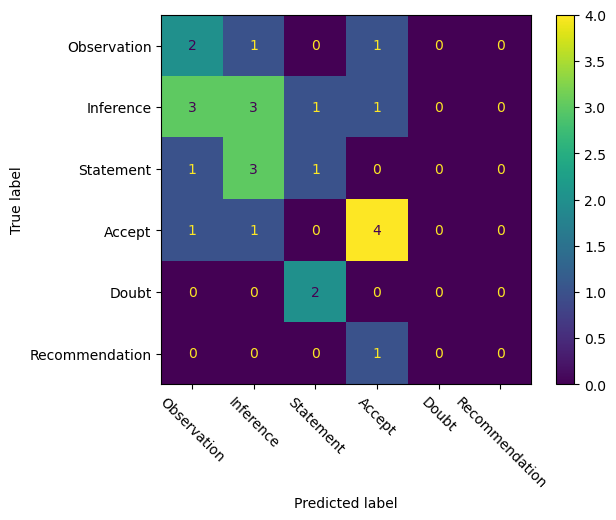

In [113]:
conf_matrix = confusion_matrix(true, pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=np.array(labels)[true.unique().tolist()].tolist()).plot()
plt.xticks(rotation=-45)

In [114]:
true = true.cpu()
pred = pred.cpu()
accuracy = accuracy_score(true, pred)

micro_f1_score = f1_score(true, pred, average="micro")
macro_f1_score = f1_score(true, pred, average="macro")
weighted_f1_score = f1_score(true, pred, average="weighted")

micro_precision = precision_score(true, pred, average="micro")
macro_precision = precision_score(true, pred, average="macro")
weighted_precision = precision_score(true, pred, average="weighted")

micro_recall = recall_score(true, pred, average="micro")
macro_recall = recall_score(true, pred, average="macro")
weighted_recall = recall_score(true, pred, average="weighted")

if output_size == 1:
    auroc = roc_auc_score(true.cpu(), pred_probs.cpu())
else: 
    auroc = roc_auc_score(true, pred_probs, multi_class='ovo')

In [41]:
print(f"accuracy : {accuracy:.4f}\n")

print(f"micro f1_score : {micro_f1_score:.4f}")
print(f"macro f1_score : {macro_f1_score:.4f}")
print(f"weighted f1_score : {weighted_f1_score:.4f}\n")

print(f"micro precision : {micro_precision:.4f}")
print(f"macro precision : {macro_precision:.4f}")
print(f"weighted precision : {weighted_precision:.4f}\n")

print(f"micro recall : {micro_recall:.4f}")
print(f"macro recall : {macro_recall:.4f}")
print(f"weighted recall : {weighted_recall:.4f}\n")

print(f"auroc : {auroc:.4f}")

accuracy : 0.3846

micro f1_score : 0.3846
macro f1_score : 0.2627
weighted f1_score : 0.3561

micro precision : 0.3846
macro precision : 0.2470
weighted precision : 0.3393

micro recall : 0.3846
macro recall : 0.2903
weighted recall : 0.3846

auroc : 0.6208


Val set eval

In [123]:
true, pred, pred_probs = rec_test(model, rec_val_loader, 2, hyperparam, modalities, output_size)

In [124]:
print(true.unique(return_counts=True))
print(pred.unique(return_counts=True))

(tensor([0, 1, 2, 3], dtype=torch.int32), tensor([5, 5, 6, 7]))
(tensor([0, 1, 2, 3, 5], dtype=torch.int32), tensor([5, 4, 9, 4, 1]))


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Observation'),
  Text(1, 0, 'Inference'),
  Text(2, 0, 'Statement'),
  Text(3, 0, 'Accept'),
  Text(4, 0, 'Recommendation')])

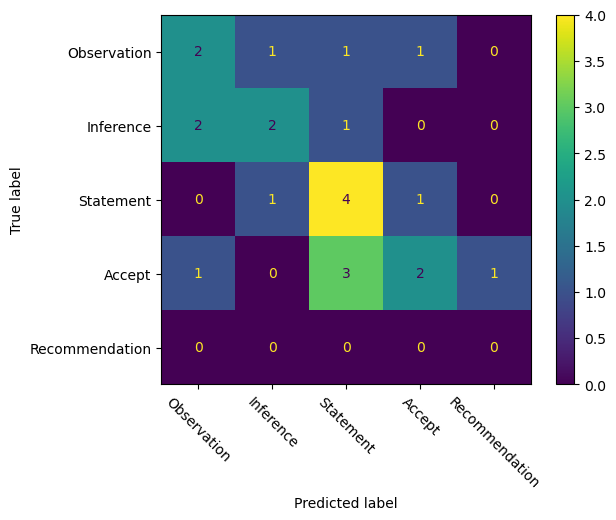

In [129]:
conf_matrix = confusion_matrix(true, pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=np.array(labels)[pred.unique().tolist()].tolist()).plot()
plt.xticks(rotation=-45)

In [45]:
true = true.cpu()
pred = pred.cpu()
accuracy = accuracy_score(true, pred)

micro_f1_score = f1_score(true, pred, average="micro")
macro_f1_score = f1_score(true, pred, average="macro")
weighted_f1_score = f1_score(true, pred, average="weighted")

micro_precision = precision_score(true, pred, average="micro")
macro_precision = precision_score(true, pred, average="macro")
weighted_precision = precision_score(true, pred, average="weighted")

micro_recall = recall_score(true, pred, average="micro")
macro_recall = recall_score(true, pred, average="macro")
weighted_recall = recall_score(true, pred, average="weighted")

# if output_size == 1:
#     auroc = roc_auc_score(true.cpu(), pred_probs.cpu())
# else: 
#     auroc = roc_auc_score(true, pred_probs, multi_class='ovo')

In [46]:
print(f"accuracy : {accuracy:.4f}\n")

print(f"micro f1_score : {micro_f1_score:.4f}")
print(f"macro f1_score : {macro_f1_score:.4f}")
print(f"weighted f1_score : {weighted_f1_score:.4f}\n")

print(f"micro precision : {micro_precision:.4f}")
print(f"macro precision : {macro_precision:.4f}")
print(f"weighted precision : {weighted_precision:.4f}\n")

print(f"micro recall : {micro_recall:.4f}")
print(f"macro recall : {macro_recall:.4f}")
print(f"weighted recall : {weighted_recall:.4f}\n")

# print(f"auroc : {auroc:.4f}")

accuracy : 0.2785

micro f1_score : 0.2785
macro f1_score : 0.1148
weighted f1_score : 0.3899

micro precision : 0.2785
macro precision : 0.1846
weighted precision : 0.8827

micro recall : 0.2785
macro recall : 0.2695
weighted recall : 0.2785

